In [ ]:
!pip show torch

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install pytorch-lightning

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
DATA_DIR = './data/CamVid/'

if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

Loading data...
Done!


In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_val_dir = os.path.join(DATA_DIR, 'val')
y_val_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [ ]:
from PIL import Image
import numpy as np

In [ ]:
image = Image.open("./data/CamVid/test/0001TP_008550.png")

In [ ]:
np.array(image).shape

(360, 480, 3)

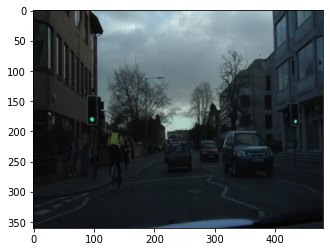

In [ ]:
plt.imshow(np.array(image))

In [ ]:
mask = Image.open("./data/CamVid/testannot/0001TP_008550.png")

In [ ]:
np.array(mask).shape

(360, 480)

In [ ]:
np.array(mask)

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [ 3,  3,  3, ..., 11, 11, 11],
       [ 3,  3,  3, ..., 11, 11, 11],
       [ 3,  3,  3, ..., 11, 11, 11]], dtype=uint8)

In [ ]:
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']

In [ ]:
classes = ['sky',"building"]

In [ ]:
class_values = [CLASSES.index(cls.lower()) for cls in classes]

In [ ]:
import torchvision.transforms as transforms

In [ ]:
mask = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x*255
])(mask).squeeze()

In [ ]:
mask.shape

torch.Size([360, 480])

In [ ]:
mask

tensor([[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        ...,
        [ 3.,  3.,  3.,  ..., 11., 11., 11.],
        [ 3.,  3.,  3.,  ..., 11., 11., 11.],
        [ 3.,  3.,  3.,  ..., 11., 11., 11.]])

In [ ]:
masks = [(mask == v) for v in class_values]

In [ ]:
masks

[tensor([[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]),
 tensor([[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]])]

In [ ]:
import torch

In [ ]:
mask.shape

torch.Size([360, 480])

In [ ]:
mask = torch.stack(masks, axis=0)

In [ ]:
mask.shape

torch.Size([2, 360, 480])

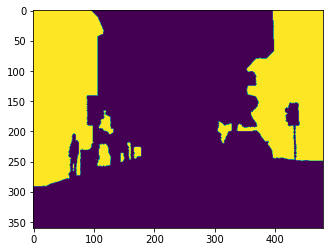

In [ ]:
plt.imshow(mask[1])

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset 

In [ ]:
class SegmentationDataset(Dataset):

    CLASSES = ['sky',"building"]
    
    def __init__(self, images_dir,  masks_dir, preprocessing=False,):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        self.class_values = list(range(len(self.CLASSES)))
        
        self.preprocessing = preprocessing
        self.image_transform = transforms.Compose([
                                    transforms.CenterCrop((352,480)),
                                    transforms.ToTensor()])
        self.mask_transform = transforms.Compose([
                                    transforms.CenterCrop((352,480)),
                                    transforms.ToTensor(),
                                    lambda x: x*255])
    
    def __getitem__(self, i):
        image = Image.open(self.images_fps[i])
        mask =  Image.open(self.masks_fps[i])

        image = self.image_transform(image)
        mask = self.mask_transform(mask).squeeze(0)
        masks = [(mask == v) for v in self.class_values]
        mask = torch.stack(masks, axis=0)

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [ ]:
dataset = SegmentationDataset(x_train_dir, y_train_dir)

In [ ]:
image, mask = dataset[0]

In [ ]:
image.shape

torch.Size([3, 352, 480])

In [ ]:
mask.shape

torch.Size([2, 352, 480])

In [ ]:
mask

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True, False,  True],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

In [ ]:
import pytorch_lightning as pl

In [ ]:
class DataModule(pl.LightningDataModule):
    def __init__(self, x_train_dir, y_train_dir,x_val_dir, y_val_dir, x_test_dir, y_test_dir, batch_size = 16):
        super().__init__()
        self.x_train_dir = x_train_dir
        self.y_train_dir = y_train_dir

        self.x_val_dir = x_val_dir
        self.y_val_dir = y_val_dir

        self.x_test_dir = x_test_dir
        self.y_test_dir = y_test_dir

        self.batch_size = batch_size

    def setup(self, stage = None):
        
        self.train_dataset = SegmentationDataset(self.x_train_dir, self.y_train_dir)
        self.val_dataset = SegmentationDataset(self.x_val_dir, self.y_val_dir)
        self.test_dataset = SegmentationDataset(self.x_test_dir, self.y_test_dir)
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)
      
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)



In [ ]:
dm = DataModule(x_train_dir,y_train_dir, x_val_dir, y_val_dir, x_test_dir, y_test_dir)

In [ ]:
!pip install torchgeometry

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchgeometry.losses import DiceLoss
import segmentation_models_pytorch as smp


In [ ]:
class SegmentationModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes):
        super().__init__()
        self.model = smp.Unet('resnet34', encoder_weights='imagenet')

        self.loss_fn = DiceLoss()
        self.out_classes = out_classes

    def forward(self, image):
        mask = self.model(image)
        return mask

    def training_step(self, batch, batch_idx):
        
        image, mask = batch

        pred_mask = self.forward(image)
        
        loss = self.loss_fn(pred_mask.float(), mask.to(torch.int64))

        pred_mask = torch.argmax(pred_mask,dim=1)

        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask, mask, mode='multilabel', threshold=0.5)
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")


        self.log('train_loss', loss, on_step= True, on_epoch = True)
        self.log('iou_score', iou_score, on_step= True, on_epoch = True)


        return loss

    def validation_step(self, batch, batch_idx):
      
        image, mask = batch

        pred_mask = self.forward(image)
        
        loss = self.loss_fn(pred_mask.float(), mask.to(torch.int64))



        self.log('val_loss', loss, on_step= True, on_epoch = True)

        return loss


  
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
model = SegmentationModel("FPN", "se_resnext50_32x4d", in_channels=3, out_classes=len(SegmentationDataset.CLASSES))

In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="segmentation model")

In [ ]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=20,
    logger = logger
)

trainer.fit(model, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RuntimeError: ignored

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir lightning_logs

<IPython.core.display.Javascript object>

# Test

In [ ]:
test_image, test_mask = dm.test_dataset[0]

In [ ]:
output_mask = model(test_image.unsqueeze(0))[0]

In [ ]:
output_mask

tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], grad_fn=<SelectBackward0>)

In [ ]:
output_mask.shape

torch.Size([1, 352, 480])

Liczby najbardziej prawdopodobną klasę dla każdego piksela

In [ ]:
predicted_class = torch.argmax(output_mask,dim=0)

In [ ]:
predicted_class.shape

torch.Size([352, 480])

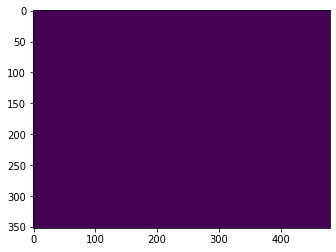

In [ ]:
plt.imshow(predicted_class.cpu().detach().numpy())

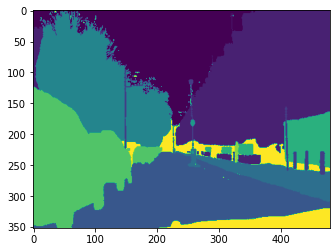

In [ ]:
plt.imshow(test_mask)

Model nie wypada idealnie ale ma bardzo mało danych treningowych, można by go usprawnić dodając augmentacje https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

# Zadanie 3
Spróbuj uzyskać lepszą segmentację przy pomocy augmentacji. W tym celu zdefiniuj nową klasę dataset. Wytrenuj model na nowym zbiorze danych i porównaj maskę z maską z poprzedniego modelu.

In [ ]:
class SegmentationDatasetWithAugmentation(Dataset):

    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = list(range(len(self.CLASSES)))
        
        self.preprocessing = preprocessing
        # TODO: dodaj augmentację
        self.image_transform = transforms.Compose([
                                    transforms.CenterCrop((352,480)),
                                    transforms.ToTensor()])
        self.mask_transform = transforms.Compose([
                                    transforms.CenterCrop((352,480)),
                                    transforms.ToTensor(),
                                    lambda x: x*255])
    
    def __getitem__(self, i):
        
        # read data
        image = Image.open(self.images_fps[i])
        mask = Image.open(self.masks_fps[i])
        
        # extract certain classes from mask (e.g. cars)
        image = self.image_transform(image)
        mask = self.mask_transform(mask).squeeze()

        

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [ ]:
class DataModuleWithAugmentation(pl.LightningDataModule):
    def __init__(self, x_train_dir, y_train_dir,x_val_dir, y_val_dir, x_test_dir, y_test_dir, batch_size = 16):
        super().__init__()
        self.x_train_dir = x_train_dir
        self.y_train_dir = y_train_dir

        self.x_val_dir = x_val_dir
        self.y_val_dir = y_val_dir

        self.x_test_dir = x_test_dir
        self.y_test_dir = y_test_dir

        self.batch_size = batch_size

    def setup(self, stage = None):
        
        self.train_dataset = SegmentationDatasetWithAugmentation(self.x_train_dir, self.y_train_dir)
        self.val_dataset = SegmentationDatasetWithAugmentation(self.x_val_dir, self.y_val_dir)
        self.test_dataset = SegmentationDatasetWithAugmentation(self.x_test_dir, self.y_test_dir)
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)
      
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [ ]:
dm = DataModuleWithAugmentation(x_train_dir,y_train_dir, x_val_dir, y_val_dir, x_test_dir, y_test_dir)
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=20,
    logger = logger
)

trainer.fit(model, dm)